In [1]:
import pandas as pd
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import random
from sklearn.preprocessing import  OneHotEncoder

In [2]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense
from keras.layers import Flatten, Activation, Concatenate
from keras.losses import categorical_crossentropy
from keras.optimizers import adam
import keras.backend as K

Using TensorFlow backend.


In [3]:
FOLDER = '../../data_kaggle/kuzushiji/'
IMAGES = FOLDER + 'train_images/'
CHARS = FOLDER + 'chars/'
MODELS = FOLDER + 'models/'
print(os.listdir(FOLDER))

['unicode_translation.csv', 'train_images', 'sample_submission.csv', 'train.csv', 'kuzushiji-recognition.zip', 'output', 'test_images', 'chars', 'models']


In [4]:
from ssd_utils.ssd_cnn import SSD_CNN
from ssd_utils.ssd_box import DefaultBox, BBoxUtility
from ssd_utils.ssd_gen import Generator
from ssd_utils.ssd_training import MultiboxLoss

In [5]:
df_train = pd.read_csv(FOLDER + 'train.csv')
df_sub = pd.read_csv(FOLDER + 'sample_submission.csv')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(FOLDER + 'unicode_translation.csv').values}

with open(MODELS + 'ohe.pickle', 'rb') as f:
    ohe = pickle.load(f)

In [6]:
df_sub_idx = df_sub.set_index("image_id")
df_train_idx = df_train.set_index("image_id")
idx_train = df_train['image_id']

In [7]:
num_classes = len(unicode_map)

In [8]:
DB = DefaultBox((1000,1000,1), 10, 100, [2,3], [0.1, 0.1, 0.2, 0.2]) 
DB.compute_output_shape(np.array([1,10,20]))
# var = K.ones(shape=( 100, 100))
# priors = K.eval(DB(var))

(1, 1200, 8)

In [9]:
var1 = K.ones(shape=(1, 14, 14))
priors1 = K.eval(DB(var1)).reshape(-1,8)

var2 = K.ones(shape=(1, 28, 28))
priors2 = K.eval(DB(var2)).reshape(-1,8)

var3 = K.ones(shape=(1, 10, 10))
priors3 = K.eval(DB(var3)).reshape(-1,8)

priors = np.vstack([priors2,  priors1])

In [10]:
BBU = BBoxUtility(num_classes, priors)

In [11]:
len_idx = len(idx_train)
rand_idx = random.sample(list(idx_train), len_idx)
train_keys = rand_idx[:int(len_idx*0.8)]
val_keys = rand_idx[int(len_idx*0.8):]

In [12]:
BBU = BBoxUtility(num_classes, priors, nms_thresh=0.1)

df_idx = df_train_idx 
bbox_util = BBU
batch_size = 2
path_prefix = IMAGES
image_size = (1000, 1000, 1)

gen =  Generator(df_idx = df_train_idx, 
                 bbox_util = BBU,
                 batch_size = batch_size,
                 path_prefix = IMAGES,
                 ohe = ohe,
                 train_keys = train_keys,
                 val_keys = val_keys,
                 image_size=image_size)

In [13]:
ssd_obj = SSD_CNN(num_classes, cnn_size=(100, 100, 1), ssd_size=image_size)
cnn_model = ssd_obj.load(MODELS + 'model.hdf5')
ssd_model = ssd_obj.build_ssd()

In [14]:
lr = 3e-4
ssd_model.compile(optimizer=adam(lr), 
                  loss=MultiboxLoss(num_classes, neg_pos_ratio=1.0).compute_loss)

In [15]:
ssd_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ssd_input (InputLayer)          (None, 1000, 1000, 1 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 1000, 1000, 3 320         ssd_input[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 1000, 1000, 3 9248        conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 500, 500, 32) 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [ ]:
history = ssd_model.fit_generator(gen.generate(True),
                                  steps_per_epoch=gen.train_batches,
                                  epochs=10,
                                  verbose=1,
                                  validation_data=gen.generate(False),
                                  validation_steps=gen.val_batches)

Epoch 1/10
3103/3104 [============================>.] - ETA: 1s - loss: 6.0634

In [17]:
key = idx_train[0]
img_path = path_prefix + key + '.jpg'
img_path

'../../data_kaggle/kuzushiji/train_images/100241706_00004_2.jpg'

In [18]:
from keras.preprocessing import image

In [19]:
img = image.load_img(img_path)
img = image.img_to_array(img)/255


In [20]:
img = image.load_img(img_path,target_size=(image_size[1],image_size[0]))
img = image.img_to_array(img)/255

# original_x = img.shape[1]
# original_y = img.shape[0]
# cut_x = original_x // 2
# cut_y = original_y // 3

# img = img[cut_y:cut_y*2, :cut_x, :]
img.shape

(1000, 1000, 3)

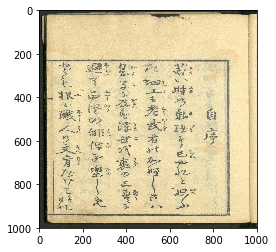

In [21]:
plt.imshow(img)
plt.show()

In [22]:
# img = image.img_to_array((image.array_to_img(img).resize((image_size[1],image_size[0]))))

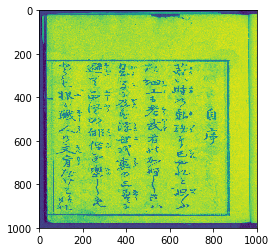

In [23]:
img_gray = img.dot([0.299, 0.587, 0.114])
plt.imshow(img_gray)
plt.show()

In [24]:
pred = ssd_model.predict(img_gray[np.newaxis, :, :, np.newaxis])

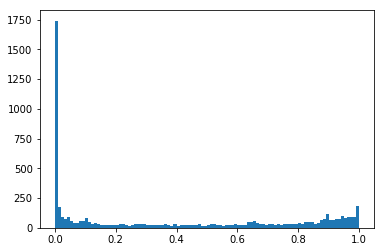

In [25]:
plt.hist(pred[0,:, 4:-8][:,0], bins=100)
plt.show()

In [26]:
pd.Series(ohe.inverse_transform(pred[0,:, 4:-8]).reshape(-1)).value_counts()

U+0031    4855
U+9BF1      47
U+5B51      40
U+9D5C      33
U+7D5E      32
U+5109      31
U+7E3D      26
U+7FC5      22
U+813E      21
U+5F0F      20
U+6867      17
U+86EE      15
U+7766      15
U+60EE      15
U+3057      15
U+55AE      15
U+8E47      14
U+89BF      14
U+540F      14
U+8E2A      13
U+9C4A      13
U+7AAE      12
U+30CB      12
U+3089      11
U+9855      11
U+9DC2      11
U+304B      11
U+7FB9      11
U+8D99      10
U+53EF      10
          ... 
U+8A13       1
U+3042       1
U+7ACA       1
U+4E16       1
U+840C       1
U+5927       1
U+8A2D       1
U+6B63       1
U+7BAD       1
U+6AFA       1
U+66AB       1
U+52C5       1
U+5EAD       1
U+96F6       1
U+79E6       1
U+8328       1
U+72E9       1
U+5224       1
U+8B2B       1
U+793A       1
U+6C17       1
U+4FC2       1
U+304F       1
U+54C0       1
U+4E43       1
U+5442       1
U+626E       1
U+8077       1
U+5DDD       1
U+9C24       1
Length: 270, dtype: int64

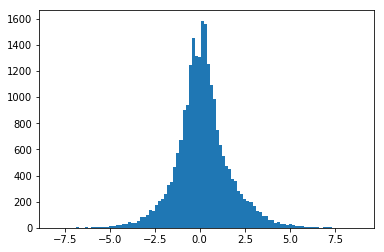

In [27]:
plt.hist(pred[0,:, :4].reshape(-1), bins=100)
plt.show()

In [28]:
pred[0][:,2].shape

(5880,)

In [29]:
result = bbox_util.detection_out(pred)

In [30]:
result[0].shape

(50, 6)

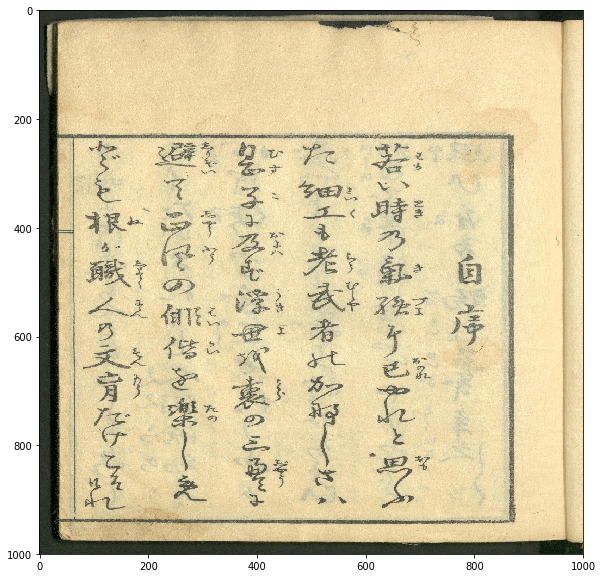

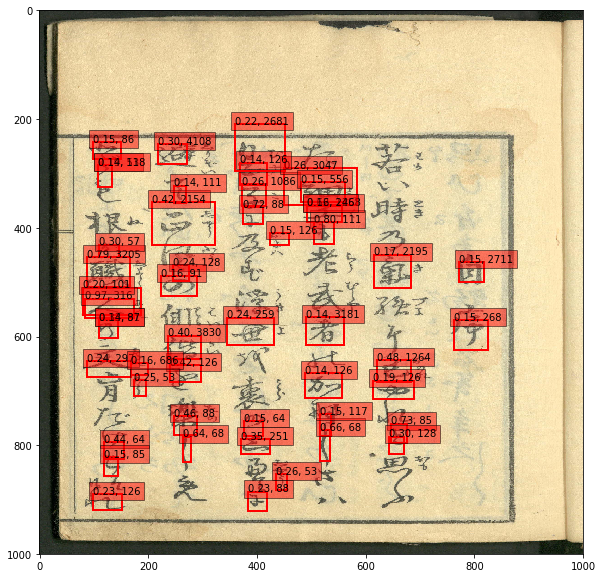

In [49]:
# Parse the outputs.`
num_label = len(unicode_map)

det_label = result[0][:, 0]
det_conf = result[0][:, 1]
det_xmin = result[0][:, 2]
det_ymin = result[0][:, 3]
det_xmax = result[0][:, 4]
det_ymax = result[0][:, 5]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.01]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()
plt.figure(figsize=(10,10))

plt.imshow(img)
currentAxis = plt.gca()

for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * img.shape[1]))
    ymin = int(round(top_ymin[i] * img.shape[0]))
    xmax = int(round(top_xmax[i] * img.shape[1]))
    ymax = int(round(top_ymax[i] * img.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
#     label_code = np.zeros((1, num_label))
#     label_code[0,label] = 1
#     label_unicode = ohe.inverse_transform(label_code)
#     label_char = unicode_map[label_unicode[0][0]]
    display_txt = '{:0.2f}, {}'.format(score, label)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
#     color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='red', linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':'red', 'alpha':0.5})

plt.show()

In [48]:
label = 3181
label_code = np.zeros((1, num_label))
label_code[0,label] = 1
label_unicode = ohe.inverse_transform(label_code)
label_char = unicode_map[label_unicode[0][0]]
label_char

'者'

In [50]:
ssd_model.save(MODELS + '20190918_ssd_model_f.hdf5', include_optimizer=False)
ssd_model.save(MODELS + '20190918_ssd_model_t.hdf5', include_optimizer=True)